## **ECOM90025 ADA Tutorial 6** ##

In [ ]:
# package library
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

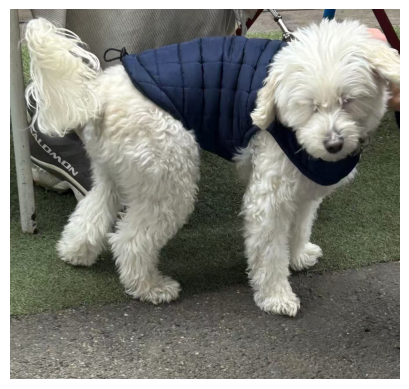

In [ ]:
#https://drive.google.com/file/d/15R4GwEYpDyLEulbz35OW0tnwJe5gV3ve/view?usp=drive_link
url = 'https://drive.google.com/uc?id=15R4GwEYpDyLEulbz35OW0tnwJe5gV3ve'

# Download and open the image
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

### **Construct Simulations!**

In [ ]:
# What is data simulation?
# Generate data ourselves knowing the underlying pattern

# What is the benefit of data simulations?
# Comparison, coz we know the true process

# Simulation requirement for this time:
# - two types: male and female
# - treatment: before treatment all 0, after treament make =1, female =2 (mean outcome)
# - variance: type normal, sigma =1
# - sample size: 50/50, 100 in total

# Set the seed for replication
np.random.seed(135)

# set the numerical parameters according to above
mu_m_0 = 0
mu_m_1 = 1
mu_f_0 = 0
mu_f_1 = 2
sigma  = 1    # common std. deviation for all groups
n0     = 100
n1     = 50

# number of replications
B      = 1000 # This is different to sample size

# Initialize the treatment effect vector for storing estimated TEs
TE     = []

# Initialize the loop
# for each replication
for b in tqdm(range(B), desc="Simulating data"):
    # generate outcome for no-treatment
    y0 = np.concatenate((np.random.normal(loc=mu_f_0, scale=1, size=n0//2),
                         # normal as type(mean, variance, size of subsample)
                          np.random.normal(loc=mu_m_0, scale=1, size=n0//2)))
    # generate outcome for treatment
    y1 = np.concatenate((np.random.normal(loc=mu_m_1, scale=1, size=n1//2),
                          np.random.normal(loc=mu_f_1, scale=1, size=n1//2)))

    # calculate the average treatment effect for each replication
    TE.append(np.mean(y1) - np.mean(y0))


# Histogram
# (Note here that I'm deliberately writing out the range of TE values for
# the histogram; you'll see why on the next part of this question)
fig = px.histogram(TE,
                   nbins   = 30,
                   title   = "Histogram of Treatment Effects (50% Balance)",
                   range_x = [0.9,2.5])
fig.show()

# calculate the average effect for the 1000 replications
te_mean = np.mean(TE)
print(te_mean)

# what is the true average treatment effect?
# 0.5*(2-0) + 0.5*(2-0) = 1.5

Simulating data: 100%|██████████| 1000/1000 [00:00<00:00, 6747.40it/s]


1.488436479645647


In [ ]:
# If male only have proportion of 10%?
# set seed again to make sure the random pattern same (so results comparable)
np.random.seed(135)

# reset the y0 and y1 matrix for the new proportion
del y0
del y1
TE = []

# Initiate the new loop drawing samples
for b in tqdm(range(B), desc="Simulating data"):
    # for no treatment (note the size part change)
    y0 = np.concatenate((np.random.normal(loc=mu_f_0, scale=1, size=round(n0*0.1)),
                          np.random.normal(loc=mu_m_0, scale=1, size=round(n0*0.9))))
    # for treatment part
    y1 = np.concatenate((np.random.normal(loc=mu_m_1, scale=1, size=round(n1*0.1)),
                          np.random.normal(loc=mu_f_1, scale=1, size=round(n1*0.9))))

    # calculate average treatment effect for each replication
    TE.append(np.mean(y1) - np.mean(y0))

# redo the histogram
fig = px.histogram(TE,
           nbins   = 30,
           title   = "Histogram of Treatment Effects (10% Male)",
           range_x = [0.9,2.5])
fig.show()

# redo the average ATE calculation across all samples
te_mean = np.mean(TE)
print(te_mean)

# what's the theoretical value:
# 0.9 * 2 + 0.1 * 1 = 1.9

Simulating data: 100%|██████████| 1000/1000 [00:00<00:00, 32736.54it/s]


1.888436479645647


### **Generate data for regression simulations**

In [ ]:
# to simulate regression, we can't just generate data and do subtracion
# Therefore we need to generate a data frame first
np.random.seed(135)

# Simulate individual genders
g0 = np.concatenate((np.zeros(n0//2), np.ones(n0//2)))  # 0 for male, 1 for female
g1 = np.concatenate((np.zeros(n1//2), np.ones(n1//2)))  # 0 for male, 1 for female

# Simulate individual observations for control and treatment groups
y0 = np.concatenate((np.random.normal(loc=mu_m_0, scale=1, size=n0//2),
                      np.random.normal(loc=mu_f_0, scale=1, size=n0//2)))
y1 = np.concatenate((np.random.normal(loc=mu_m_1, scale=1, size=n1//2),
                      np.random.normal(loc=mu_f_1, scale=1, size=n1//2)))

# Create a Pandas DataFrame
df = pd.DataFrame({
    'y_i': np.concatenate((y0, y1)),
    'd_i': np.concatenate((np.zeros(n0), np.ones(n1))),  # 0 for control, 1 for treatment
    'g_i': np.concatenate((g0, g1))
})

# Display the first few rows of the generated data
df.head()

# how many rows will this dataframe have? (100 n0+ 50n1 =150 right?)

,y_i,d_i,g_i
0,-1.264856,0.0,0.0
1,1.184281,0.0,0.0
2,0.355047,0.0,0.0
3,-0.297943,0.0,0.0
4,-0.533484,0.0,0.0


In [ ]:
# Let's check our data frame for a bit
cross_tab = pd.crosstab(df['d_i'], df['g_i'])

# Display the cross-tabulation
print(cross_tab)

# for g_i = 0, we have 50 d_i=0, 25 d_i=1
# and we read rest of the entries in a similar way

g_i  0.0  1.0
d_i          
0.0   50   50
1.0   25   25


In [ ]:
# compute the mean outcome within each subgroup.
pivot_table = df.pivot_table(values='y_i', index='d_i', columns='g_i', aggfunc='mean')

# Display the pivot table
print(pivot_table)

g_i       0.0       1.0
d_i                    
0.0  0.065884  0.019140
1.0  1.254388  1.847057


### **Regression simulations**

The DGP in Section *Heterogeneity and ATE* can be represented in a regression form as
$$y=\alpha_g + \gamma_g d + ɛ,$$
where $ɛ\sim N(0,1)$.

- What is the ATE in terms of these parameters?
- Use the first setting (half female and half male).

In [ ]:
# Note here both the intercept and the coefficient depend on gender
# technically we will be getting two gammas and two alphas
# each group capture ATE but per group
model = smf.ols(formula='y_i ~ g_i * d_i', data=df)
# this model form is actually y_i = alpha + beta*g_i + gamma*d_i + delta * (d_i * g_i) + error
result = model.fit()

# Display the regression summary
print(result.summary())

# how to calcultae each coefficient
# alpha_m = 0.0659
# alpha_f = 0.0659 - 0.0467 = −0.0467
# gamma_m = 1.1885
# gamma_f = 1.1885 + 0.6394 = 1.8279
# how does that compare to the true value?

# compute the overall ATE
# 0.5 * ​(1.1885+1.8279) = 1.5082

                            OLS Regression Results                            
Dep. Variable:                    y_i   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     33.90
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.10e-16
Time:                        10:50:27   Log-Likelihood:                -193.07
No. Observations:                 150   AIC:                             394.1
Df Residuals:                     146   BIC:                             406.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0659      0.126      0.524      0.6

If, instead, we estimate a simple regression model instead
$$y = \alpha_g + \gamma d + u,$$
while the true model has heterogeneity in gender.

- What is $\gamma$? Is it still ATE?

In [ ]:
# note here only alpha has heterogenity
model = smf.ols(formula='y_i ~ g_i + d_i', data=df)
result = model.fit()

# Display the regression summary
print(result.summary())

# how to calculate each coefficient
# alpha_m = -0.0407
# alpha_f = -0.0407 + 0.1664 = 0.1257
# gamma = 1.5082
# Note that when you compare this with the ATE calculation above! - same right?

                            OLS Regression Results                            
Dep. Variable:                    y_i   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     47.61
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.14e-16
Time:                        11:00:24   Log-Likelihood:                -195.26
No. Observations:                 150   AIC:                             396.5
Df Residuals:                     147   BIC:                             405.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0407      0.116     -0.351      0.7

If, instead, we estimate a simple regression model
$$y = \alpha + \gamma d + u,$$
while the true model has heterogeneity in gender.

- What is $\gamma$? Is it still ATE?

In [ ]:
# Now this is the full moedel without heterogenity
model = smf.ols(formula='y_i ~ d_i', data=df)
result = model.fit()

# Display the regression summary
print(result.summary())

# The gamma is consistent with the previous calculation again!
# why is this not the same with the simulation at the start
# because over there we run 1000 replication, this is only one sample

                            OLS Regression Results                            
Dep. Variable:                    y_i   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     93.76
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.76e-17
Time:                        11:50:07   Log-Likelihood:                -195.91
No. Observations:                 150   AIC:                             395.8
Df Residuals:                     148   BIC:                             401.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0425      0.090      0.473      0.6

###